In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Define Process Parameters

In [2]:
T = 332.15#-35 #Temperature in Kelvin
R = 8.314 # [m^3*Pa/K/mol]
t_rn = 100.0 # Run time [h]

#Reactor 1
F1_L = 0 #Fluid inflow rate with C-source supplement
F_L_ex = 0.1 #Fluid exchange rate between tanks [m^3/h]
F1_G = 1*10**4 #gas inflow rate (from Steph: (8*10**5 * 8.314 * T)/p_m) [m^3/h]
r1 = 3 # radius of the reactor [m]
h1 = 30 # height of the reactor [m]

#mol fraction of incoming gas
y1_co = 0.4 #[mol/mol]
y1_co2 = 0.2 #[mol/mol]
y1_h2 = 0.3 #[mol/mol]
y1_o2 = 0.0 #[mol/mol]
y1_n2 = 0.0 #[mol/mol]

#Reactor 2
F2_L = 0 #Fluid inflow rate with C-source supplement [m^3/h]
F2_G = 1 * 10**3 #gas inflow rate [m^3/h]
r2 = 2 # radius of the reactor [m]
h2 = 5 # height of the reactor [m]

#mol fraction of incoming gas
y2_co = 0.0 #[mol/mol]
y2_co2 = 0.0 #[mol/mol]
y2_h2 = 0.0 #[mol/mol]
y2_o2 = 0.5 #[mol/mol]
y2_n2 = 0.5 #[mol/mol]

## Deduceable reactor parameters

reactor 1: (with Acetogens)

In [3]:
A1 = math.pi * r1**2 #reactor cross-sectional area [m^2]
V1_L = A1 * h1 * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v1_gas = F1_G/A1/3600 #average gas velocity [m/s]
Gas_holdup1 = 0.6*(v1_gas)**0.7 #from Stephanie's paper
V1_G = V1_L*Gas_holdup1

p1_t = 101325 # pressure at the top of the reactor [Pa]
p1_b = p1_t + h1 * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p1_m = (p1_b-p1_t)/math.log(p1_b/p1_t) # logarithmic mean pressure [Pa]

print(f"Reactor 1 is a bubble column reactor of {round(A1 * h1,2)}m^3, of which the broth occupies {round(V1_L,2)}m^3, and the gas {round(V1_G,2)}m^3.")

print(f"The mean logarithmic pressure in the tank is {round(p1_m,2)}[Pa]")

Reactor 1 is a bubble column reactor of 848.23m^3, of which the broth occupies 565.49m^3, and the gas 66.86m^3.
The mean logarithmic pressure in the tank is 216058.1[Pa]


reactor 2: (with Heterotroph)

In [4]:
A2 = math.pi * r2**2 #reactor cross-sectional area [m^2]
V2_L = A2 * h2 * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v2_gas = F2_G/A2/3600 #average gas velocity [m/s]
Gas_holdup2 = 0.6*(v2_gas)**0.7 #from Stephanie's paper
V2_G = V2_L*Gas_holdup2

p2_t = 101325 # pressure at the top of the reactor [Pa]
p2_b = p2_t + h2 * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p2_m = (p2_b-p2_t)/math.log(p2_b/p2_t) # logarithmic mean pressure [Pa]

print(f"Reactor 2 is a CSTR of {round(A2 * h2,2)}m^3, of which the broth occupies {round(V2_L,2)}m^3, and the gas {round(V2_G,2)}m^3.")

print(f"The mean logarithmic pressure in the tank is {round(p2_m,2)}[Pa]")


Reactor 2 is a CSTR of 62.83m^3, of which the broth occupies 41.89m^3, and the gas 1.74m^3.
The mean logarithmic pressure in the tank is 124240.44[Pa]


# Biological Parameters Acetogen

Define the ratio of carbon going to biomass and to acetone. This would in the process be determinable by tuning the expression levels of the proteins.

In [5]:
R_PX = 0.5

Growth-Associated Maintenance ATP requirements of bacteria from various sources:

10.1186/s12934-015-0336-z

10.1371/journal.pcbi.1000887

10.1016/j.ces.2014.09.004

In [6]:
ATP_ana = -np.array([40.6,27.14,26.0]).mean()*24.6/1000
ATP_m = -np.array([7.836,1.8,6.092]).mean()*24.6/1000

print('y_ATP/X =', round(ATP_ana,2), "mol ATP/CmolX")
print('m_ATP =',round(ATP_m,2), "mol ATP/CmolX/h")

y_ATP/X = -0.77 mol ATP/CmolX
m_ATP = -0.13 mol ATP/CmolX/h


In [7]:
S_Acet = pd.DataFrame({
    'HomCata':     [0,    -4,  0,    -2,   2,    0,  1, 0],
    #'CarbCata':    [-4,   0,   0,    2,    -2,   0,  1, 0],
    'HomAna':      [0,   -2.1, -0.2, -1,   1.5,  1,  0, 0]},
    #'CarbAna':     [-2.1, 0,   -0.2, 1.1,  -0.6, 1,  0, 0],
    #'HomMetCata':  [0,    -4,  0,    -1,   2,    0,  0, 1],
    #'CarbMetCata': [-4,   0,   0,    3,    -2,   0,  0, 1]},
    index=pd.Index(["CO","H2","NH3","CO2","Water","X","Acetate","Methane"]))

In [8]:
S_Het = pd.DataFrame({
    'HetAna':     [-0.5, -0.45,-0.2, 0,  0,    1.4,  1, 0],
    'HetProd':    [-1.0, 0,    0,    -1, 0.5,  0.5,  0, 0.5],
    'HetCata':    [-1.0, -2,   0,    0,  2,    2,    0, 0]},
    index=pd.Index(["Acetate","O2","NH3","H","CO2","Water","X","Acetone"]))

<div style="text-align: center">  $ S_I = \displaystyle S_{I,ana} + \frac{-ATP_{ana}} {ATP_{cata}} * S_{I,cata} $
</div>

In [9]:
ATP_hom_cata = 0.32
ATP_het_cata = 3.44
ATP_het_prod = -0.5

S_Acet["Growth"] = S_Acet.HomCata*-ATP_ana/ATP_hom_cata + S_Acet.HomAna

S_Het["Growth"] = S_Het.HetCata*-ATP_ana/ATP_het_cata + S_Het.HetAna
S_Het["Production"] = S_Het.HetCata*-ATP_het_prod/ATP_het_cata + S_Het.HetProd
S_Het.Production = -S_Het.Production/S_Het.Production.Acetate
S_Het["Engineered"] = S_Het.Production/S_Het.Production.Acetone*R_PX + S_Het.Growth/S_Het.Growth.X*(1-R_PX)

### Michaelis-Menten Parameters

In [10]:
Ks_h2_hom =  0.000033 # from BRENDA, Clostridium acetobutylicum [mM]
Ks_co2_hom = 0.000033 # from H2: BRENDA, Clostridium acetobutylicum [mM]
Ks_o2_het =  0.000033 # from H2: BRENDA, Clostridium acetobutylicum [mM]
Ks_actt_het = 1.97 # find source. [mM]

Ki_actt_hom = 813.6 #mM Inhibition constant for acetate, from Moorella
Ki_actt_het = 1500 # estimate
Ki_actn_het = 2000 # estimate

µ_max_hom = 8.140/24 #[/h]
µ_max_het = 1/0.25 # [/h] 10.1016/j.ymben.2020.11.005 shortest in E. coli ==> doubling 15 min

# Define Transfer Rates as Functions

## Gas transfer rates

<p>For gasses that are poorly soluble in aqueous solutions, such as all the gases in the feed stream of this simulation, the mass transfer accros the phase boundary is dominated by the gas-phase film resistance. At the liquid side of the boundary, the gas concentration $C_{AGi}$ is at saturation $C_{AL}^*$. Temperature and partial pressure will determine the saturation concentration, and thus the transfer rate.</p>

<p>For a gas "A", the transfer rate is following the equation:</p>
<p>$ N_A = K_La * (C_{AL}^* - C_{AL})$</p>

REF: https://doi.org/10.1016/0017-9310(62)90032-7

In [11]:
# Load Henry's Law values
DR = pd.read_csv("../../../Data/HenrysLawData.csv", index_col = "Compound")["DR"]
HR = pd.read_csv("../../../Data/HenrysLawData.csv", index_col = "Compound")["HR"]
kh = pd.read_csv("../../../Data/HenrysLawData.csv", index_col = "Compound")["k"]
theta = 1.022 # temperature correction factor

def RT(C,T,c,cG,CG_Gas,reactor):
    if reactor == 1:
        v_gas,p_m = v1_gas,p1_m
        kLa_O2 = 0.32 * v_gas**0.7 * 1.022**(T-293.15) * 3600 # REF: 10.1016/0300-9467(84)85025-X
    elif reactor == 2:
        v_gas,p_m = v2_gas,p2_m
        kLa_O2 = 0.17 # from example in doran book, get better one.
    Csat = HR[C] * math.e**(kh[C]*(1/T-1/298.15)) * 10**(-5) * p_m * cG/CG_Gas
    return kLa_O2 * (DR[C]/DR["O2"])**0.5 * (Csat - c)

def Csat(C, T, y,reactor):
    if reactor == 1:
        p_m = p1_m
    elif reactor == 2:
        p_m = p2_m
    return HR[C] * math.e**(kh[C]*(1/T-1/298.15)) * 10**(-5) * p_m * y

## Acetone Evaporation Rate

Assuming that all evaporation happens through gas stripping, instead of boiling, the evaporation rate can be determined based on the partial pressure of the volatile compound, temperature corrected and at a given concentration.

required equations:
 - Clausius–Clapeyron Equation
 
<p>$ P_T = e^{RT/{\Delta H_{vap}}+C}$</p>

<p>To find the constant C, a reference temperature and pressure are needed <br></p>

<p>  $ C = log_{10}(P_0) +\Delta _{vap}H/RT_0 $</p>


 - Raoult's law: the partial pressure of each component of an ideal mixture of liquids is equal to the vapor pressure of the pure component multiplied by its mole fraction in the mixture
 
<p>$ p_i = p_i^* * x_i$</p>

 - Ideal gas law
 
<p>$ P*V = n*R*T$</p>
 
<p>For a metabolite "A", the evaporative transfer rate is following the equation:</p>
<p>$ N_A = K_Ga * (C_{AG} - C_{AG}^*)$</p>

In [12]:
DH_vap = 3.1 * 10**(4) #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C67641&Mask=4#Thermo-Phase
T0, P0 = 272.95, 9290 #http://www.ddbst.com/en/EED/PCP/VAP_C4.php

#Calculate the constant C, the intersection with the y-axis
C = math.log(P0) + DH_vap/(R*T0)

print("T0 =", T0, "\nP0 =", P0, "\nC =", C)

Pt = math.exp(-DH_vap/(R*T) + C)

Kga_actn = 1 # Arbitrarly chosen, find better value if possible

def R_actn(cG_actn,c_actn):
    cG_sat = c_actn/(1000/18)*Pt/(R*T)
    return Kga_actn*(cG_actn - cG_sat)

T0 = 272.95 
P0 = 9290 
C = 22.797256092618603


# Set up Black Box Kinetic Models

## Include growth rate and NGAM through a Pirt Model

<p>Monod Equation, specific growth rate: </p>
<div style="text-align: center">  $ µ = µ_{max} * 
\displaystyle \frac{c_S}{K_S + c_S} * (1-c_P/K_{iP})$ [$h^{-1}$]
</div>

<p>According to Pirt kinetics, the specific consumption and production rates can be modelled as following: </p>
<br>
<div style="text-align: center">  $ q_i = \displaystyle \frac{µ}{Y_{Xi}} + \frac{q_p}{Y_{Pi}} + m_{NGAM,i} $ [$h^{-1}$]
</div>
<br>
<p>With:</p>
<div style="text-align: center">  $ m_{NGAM,i} = 
\displaystyle \frac{m_{NGAM}}{ATP_{cata}}*S_{i,cata}$ [$h^{-1}$]
</div>

Where:
- $Y_{IJ}$: Yield of compound I on J
- $µ$: growth rate (/h)
- $c_I$: concentration of compound I (mM)
- $K_S$: Monod substrate saturation constant (mM)
- $K_{iP}$: Product inhibition constant (mM)
- $m_{NGAM}(T)$: temperature-dependent non-growth-associated maintenance energy requirement ($kJ/h/Cmol_{biomass}$)
- $S_i$: Stoichiometric factor of compound i
- $\Delta _r G^T$: temperature-dependent Gibbs free energy of reaction per mol product ($kJ/mol$)

subscripts:
 - S: of substrate
 - X: of biomass 
 - P: of product
 - ana: in anabolic reaction
 - cata: in catabolic reaction

In [13]:
# Homoacetogenic:
def µ_hom(S1, S2, P):
    return µ_max_hom * S1/(Ks_h2_hom+S1) * S2/(Ks_co2_hom+S2) * (1-P/Ki_actt_hom)

def q_hom(C, S1, S2, P):
    growth = µ_hom(S1, S2, P)/S_Acet.Growth["X"] * S_Acet.Growth[C]
    maintenance = -ATP_m/ATP_hom_cata*S_Acet.HomCata[C]
    return growth + maintenance

# Heterotrophic:
def µ_het(S1, S2, P):
    return µ_max_het * S1/(Ks_o2_het+S1) * S2/(Ks_actt_het+S2) * (1-P/Ki_actn_het)

def q_het(C, S1, S2, P):
    growth = µ_het(S1, S2, P)/S_Het.Growth["X"] * S_Het.Growth[C]
    product = µ_het(S1, S2, P) * R_PX/S_Het.Production["Acetone"]*S_Het.Production[C]
    maintenance = -ATP_m/ATP_het_cata*S_Het.HetCata[C]
    return growth + product + maintenance

# Plot growth and production rates

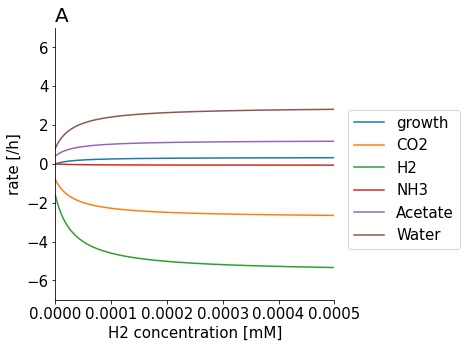

In [14]:
c_H2 = np.arange(0,0.0005,0.000001)
c_CO2 = 10

plt.figure(figsize=(5,5))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

#Output results
plt.title("A", fontdict = {'fontsize': 20}, loc = "left")
plt.axis([0, 0.0005, -7, 7])
plt.xlabel('H2 concentration [mM]', fontsize=15)
plt.ylabel('rate [/h]', fontsize=15)
plt.plot(c_H2, µ_hom(c_H2, c_CO2, 0))
plt.plot(c_H2, q_hom("CO2",c_H2, c_CO2, 0))
plt.plot(c_H2, q_hom("H2",c_H2, c_CO2, 0))
plt.plot(c_H2, q_hom("NH3",c_H2, c_CO2, 0))
plt.plot(c_H2, q_hom("Acetate",c_H2, c_CO2, 0))
plt.plot(c_H2, q_hom("Water",c_H2, c_CO2, 0))
plt.legend(['growth','CO2',"H2","NH3","Acetate","Water"], fontsize=15,bbox_to_anchor=(1.05, 0.7), loc='upper left', borderaxespad=0.)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

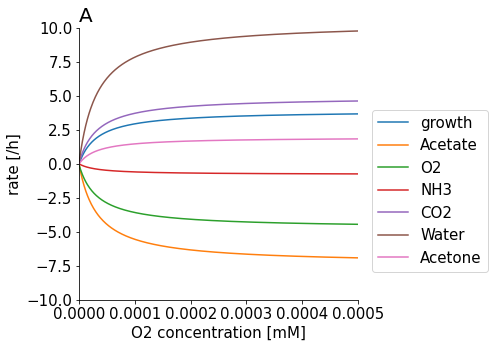

In [15]:
c_o2 = np.arange(0,0.1,0.000001)
c_actt = 100

plt.figure(figsize=(5,5))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

#Output results
plt.title("A", fontdict = {'fontsize': 20}, loc = "left")
plt.axis([0, 0.0005, -10, 10])
plt.xlabel('O2 concentration [mM]', fontsize=15)
plt.ylabel('rate [/h]', fontsize=15)
plt.plot(c_o2, µ_het(c_o2, c_actt, 0))
plt.plot(c_o2, q_het("Acetate",c_o2, c_actt, 0))
plt.plot(c_o2, q_het("O2",c_o2, c_actt, 0))
plt.plot(c_o2, q_het("NH3",c_o2, c_actt, 0))
plt.plot(c_o2, q_het("CO2",c_o2, c_actt, 0))
plt.plot(c_o2, q_het("Water",c_o2, c_actt, 0))
plt.plot(c_o2, q_het("Acetone",c_o2, c_actt, 0))
plt.legend(['growth',"Acetate","O2","NH3","CO2","Water","Acetone"], fontsize=15,bbox_to_anchor=(1.05, 0.7), loc='upper left', borderaxespad=0.)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

# Set up dFBA

In [16]:
def model(z,t):
    C1_X_hom = max(0,z[0])
    C1_Actt = max(0,z[1])
    C1_Actn = max(0,z[2])
    C1_CO2 = max(0,z[3])
    C1_CO = max(0,z[4])
    C1_H2 = max(0,z[5])
    C1_O2 = max(0,z[6])
    C1_N2 = max(0,z[7])
    CG1_CO2 = max(0,z[8])
    CG1_CO = max(0,z[9])
    CG1_H2 = max(0,z[10])
    CG1_O2 = max(0,z[11])
    CG1_N2 = max(0,z[12])
    C2_X_het = max(0,z[13])
    C2_Actt = max(0,z[14])
    C2_Actn = max(0,z[15])
    C2_CO2 = max(0,z[16])
    C2_CO = max(0,z[17])
    C2_H2 = max(0,z[18])
    C2_O2 = max(0,z[19])
    C2_N2 = max(0,z[20])
    CG2_CO2 = max(0,z[21])
    CG2_CO = max(0,z[22])
    CG2_H2 = max(0,z[23])
    CG2_O2 = max(0,z[24])
    CG2_N2 = max(0,z[25])
    CG2_Actn = max(0,z[26])
    Actn_acc = max(0,z[27])
    
    CG1_Gas = CG1_CO2 + CG1_CO + CG1_H2 + CG1_O2 + CG1_N2
    CG2_Gas = CG2_CO2 + CG2_CO + CG2_H2 + CG2_O2 + CG2_N2 + CG2_Actn
    
    dC1_X_homdt = µ_hom(C1_H2, C1_CO, C1_Actt) * C1_X_hom
    dC1_Acttdt = q_hom("Acetate",C1_H2, C1_CO2, C1_Actt) * C1_X_hom + F_L_ex * (C2_Actt - C1_Actt)
    dC1_Actndt = F_L_ex * (C2_Actn - C1_Actn)
    dC1_CO2dt = q_hom("CO2",C1_H2, C1_CO2, C1_Actt) * C1_X_hom + RT("CO2",T,C1_CO2,CG1_CO2,CG1_Gas,reactor = 1) + F_L_ex * (CG2_CO2 - CG1_CO2)
    dC1_COdt = RT("CO",T,C1_CO,CG1_CO,CG1_Gas,reactor = 1) + F_L_ex * (C2_CO - C1_CO)
    dC1_H2dt = q_hom("H2",C1_H2, C1_CO2, C1_Actt) * C1_X_hom + RT("H2",T,C1_H2,CG1_H2,CG1_Gas,reactor = 1) + F_L_ex * (C2_H2 - C1_H2)
    dC1_O2dt = RT("O2",T,C1_O2,CG1_O2,CG1_Gas,reactor = 1) + F_L_ex * (C2_O2 - C1_O2)
    dC1_N2dt = RT("N2",T,C1_N2,CG1_N2,CG1_Gas,reactor = 1) + F_L_ex * (C2_N2 - C1_N2)
    dCG1_CO2dt = F1_G/V1_G * (CG1_CO2_in-CG1_CO2) - RT("CO2",T,C1_CO2,CG1_CO2,CG1_Gas,reactor = 1) * V1_L/V1_G
    dCG1_COdt = F1_G/V1_G * (CG1_CO_in-CG1_CO) - RT("CO",T,C1_CO,CG1_CO,CG1_Gas,reactor = 1) * V1_L/V1_G
    dCG1_H2dt = F1_G/V1_G * (CG1_H2_in-CG1_H2) - RT("H2",T,C1_H2,CG1_H2,CG1_Gas,reactor = 1) * V1_L/V1_G
    dCG1_O2dt = F1_G/V1_G * (CG1_O2_in-CG1_O2) - RT("O2",T,C1_O2,CG1_O2,CG1_Gas,reactor = 1) * V1_L/V1_G
    dCG1_N2dt = F1_G/V1_G * (CG1_N2_in-CG1_N2) - RT("N2",T,C1_N2,CG1_N2,CG1_Gas,reactor = 1) * V1_L/V1_G
    dC2_X_hetdt = µ_het(C2_O2, C2_Actt, C2_Actn) * C2_X_het
    dC2_Acttdt = q_het("Acetate",C2_O2, C2_Actt, C2_Actn) * C2_X_het + F_L_ex * (C1_Actt - C2_Actt)
    dC2_Actndt = q_het("Acetone",C2_O2, C2_Actt, C2_Actn) * C2_X_het + F_L_ex * (C1_Actn - C2_Actn)+ R_actn(CG2_Actn,C2_Actn) + F_L_ex * (C1_Actn - C2_Actn)
    dC2_CO2dt = q_het("CO2",C2_O2, C2_Actt, C2_Actn) * C2_X_het + RT("CO2",T,C2_CO2,CG2_CO2,CG2_Gas,reactor = 2) + F_L_ex * (CG1_CO2 - CG2_CO2)
    dC2_COdt = RT("CO",T,C2_CO,CG2_CO,CG2_Gas,reactor = 2) + F_L_ex * (C1_CO - C2_CO)
    dC2_H2dt = RT("H2",T,C2_H2,CG2_H2,CG2_Gas,reactor = 2) + F_L_ex * (C1_H2 - C2_H2)
    dC2_O2dt = q_het("O2",C2_O2, C2_Actt, C2_Actn) * C2_X_het + RT("O2",T,C2_O2,CG2_O2,CG2_Gas,reactor = 2) + F_L_ex * (C1_O2 - C2_O2)
    dC2_N2dt = RT("N2",T,C2_N2,CG2_N2,CG2_Gas,reactor = 2) + F_L_ex * (C1_N2 - C2_N2)
    dCG2_CO2dt = F2_G/V2_G * (CG2_CO2_in-CG2_CO2) - RT("CO2",T,C2_CO2,CG2_CO2,CG2_Gas,reactor = 2) * V2_L/V2_G
    dCG2_COdt = F2_G/V2_G * (CG2_CO_in-CG2_CO) - RT("CO",T,C2_CO,CG2_CO,CG2_Gas,reactor = 2) * V2_L/V2_G
    dCG2_H2dt = F2_G/V2_G * (CG2_H2_in-CG2_H2) - RT("H2",T,C2_H2,CG2_H2,CG2_Gas,reactor = 2) * V2_L/V2_G
    dCG2_O2dt = F2_G/V2_G * (CG2_O2_in-CG2_O2) - RT("O2",T,C2_O2,CG2_O2,CG2_Gas,reactor = 2) * V2_L/V2_G
    dCG2_N2dt = F2_G/V2_G * (CG2_N2_in-CG2_N2) - RT("N2",T,C2_N2,CG2_N2,CG2_Gas,reactor = 2) * V2_L/V2_G
    dCG2_Actndt = F2_G/V2_G * (0-CG2_Actn) - R_actn(CG2_Actn,C2_Actn) * V2_L/V2_G
    dAccActndt = F2_G * (CG2_Actn)
    
    return [dC1_X_homdt,dC1_Acttdt,dC1_Actndt,dC1_CO2dt,dC1_COdt,dC1_H2dt,dC1_O2dt,dC1_N2dt,dCG1_CO2dt,dCG1_COdt,dCG1_H2dt,dCG1_O2dt,dCG1_N2dt,dC2_X_hetdt,dC2_Acttdt,dC2_Actndt,dC2_CO2dt,dC2_COdt,dC2_H2dt,dC2_O2dt,dC2_N2dt,dCG2_CO2dt,dCG2_COdt,dCG2_H2dt,dCG2_O2dt,dCG2_N2dt,dCG2_Actndt,dAccActndt]

In [17]:
#initial conditions
C1_X_hom_0 = 1
C1_Actt_0 = 0.0
C1_Actn_0 = 0.0

C1_CO2_0 = Csat("CO2", T, y1_co2,1)
C1_CO_0 = Csat("CO", T, y1_co,1)
C1_H2_0 = Csat("H2", T, y1_h2,1)
C1_O2_0 = Csat("O2", T, y1_o2,1)
C1_N2_0 = Csat("H2", T, y1_n2,1)

CG1_CO2_in = y1_co2 * p1_m/(R*T)
CG1_CO_in = y1_co * p1_m/(R*T)
CG1_H2_in = y1_h2 * p1_m/(R*T)
CG1_O2_in = y1_o2 * p1_m/(R*T)
CG1_N2_in = y1_n2 * p1_m/(R*T)

C2_X_het_0 = 1
C2_Actt_0 = 0.0
C2_Actn_0 = 0.0

C2_CO2_0 = Csat("CO2", T, y1_co2,2)
C2_CO_0 = Csat("CO", T, y1_co,2)
C2_H2_0 = Csat("H2", T, y1_h2,2)
C2_O2_0 = Csat("O2", T, y1_o2,2)
C2_N2_0 = Csat("H2", T, y1_n2,2)

CG2_CO2_in = y2_co2 * p2_m/(R*T)
CG2_CO_in = y2_co * p2_m/(R*T)
CG2_H2_in = y2_h2 * p2_m/(R*T)
CG2_O2_in = y2_o2 * p2_m/(R*T)
CG2_N2_in = y2_n2 * p2_m/(R*T)
CG2_Actn_in = 0.0

C_Actn_acc_0 = 0.0

CG1_Gas_in = CG1_CO2_in + CG1_CO_in + CG1_H2_in + CG1_O2_in + CG1_N2_in
CG2_Gas_in = CG2_CO2_in + CG2_CO_in + CG2_H2_in + CG2_O2_in + CG2_N2_in + CG2_Actn_in

t = np.linspace(0,t_rn,1000)

z0 = [C1_X_hom_0,C1_Actt_0,C1_Actn_0,C1_CO2_0,C1_CO_0,C1_H2_0,C1_O2_0,C1_N2_0,CG1_CO2_in,CG1_CO_in,CG1_H2_in,CG1_O2_in,CG1_N2_in,C2_X_het_0,C2_Actt_0,C2_Actn_0,C2_CO2_0,C2_CO_0,C2_H2_0,C2_O2_0,C2_N2_0,CG2_CO2_in,CG2_CO_in,CG2_H2_in,CG2_O2_in,CG2_N2_in,CG2_Actn_in,C_Actn_acc_0]

z = odeint(model,z0,t)

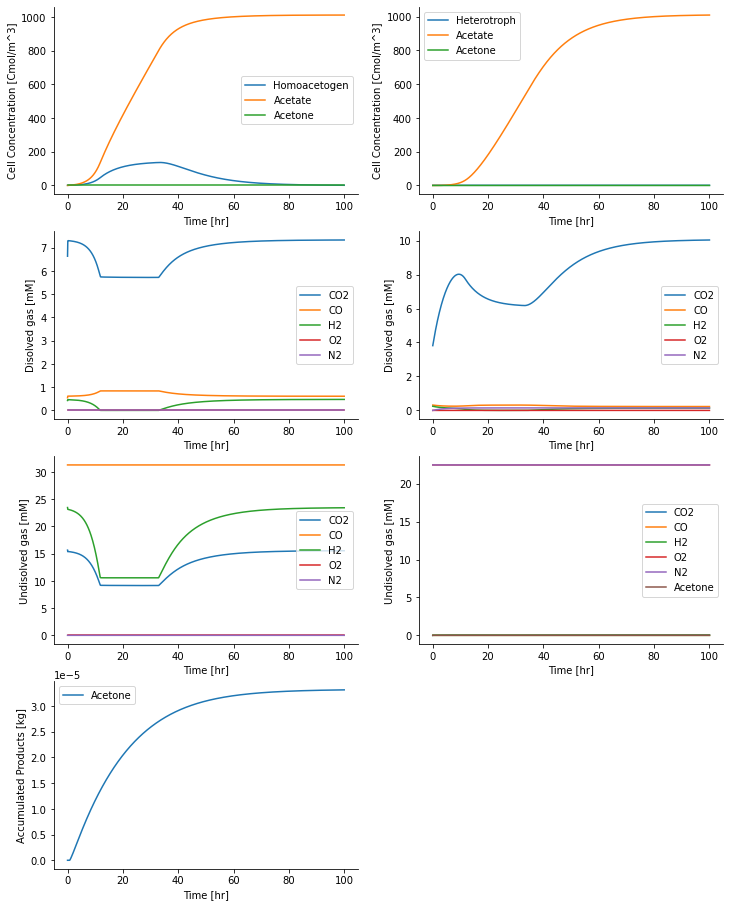

In [18]:
fig = plt.figure(figsize=(12,20))
plt.title(f"Simulation at {T-272.15}°C")

#Output results

plt.subplot(5,2,1)
plt.plot(t,z[:,0])
plt.plot(t,z[:,1])
plt.plot(t,z[:,2])
plt.xlabel('Time [hr]')
plt.ylabel('Cell Concentration [Cmol/m^3]')
#plt.axis([0, t_rn, 0, 200])
plt.legend(['Homoacetogen','Acetate','Acetone'])

plt.subplot(5,2,2)
plt.plot(t,z[:,13])
plt.plot(t,z[:,14])
plt.plot(t,z[:,15])
plt.xlabel('Time [hr]')
plt.ylabel('Cell Concentration [Cmol/m^3]')
#plt.axis([0, t_rn, 0, 200])
plt.legend(['Heterotroph','Acetate','Acetone'])

plt.subplot(5,2,3)
plt.plot(t,z[:,3])
plt.plot(t,z[:,4])
plt.plot(t,z[:,5])
plt.plot(t,z[:,6])
plt.plot(t,z[:,7])
plt.xlabel('Time [hr]')
plt.ylabel('Disolved gas [mM]')
#plt.axis([0, t_rn, 0, 30])
plt.legend(['CO2','CO',"H2","O2","N2"])

plt.subplot(5,2,4)
plt.plot(t,z[:,16])
plt.plot(t,z[:,17])
plt.plot(t,z[:,18])
plt.plot(t,z[:,19])
plt.plot(t,z[:,20])
plt.xlabel('Time [hr]')
plt.ylabel('Disolved gas [mM]')
#plt.axis([0, t_rn, 0, 30])
plt.legend(['CO2','CO',"H2","O2","N2"])

plt.subplot(5,2,5)
plt.plot(t,z[:,8])
plt.plot(t,z[:,9])
plt.plot(t,z[:,10])
plt.plot(t,z[:,11])
plt.plot(t,z[:,12])
plt.xlabel('Time [hr]')
plt.ylabel('Undisolved gas [mM]')
#plt.axis([0, t_rn, 0, 80])
plt.legend(['CO2','CO',"H2","O2","N2"])

plt.subplot(5,2,6)
plt.plot(t,z[:,21])
plt.plot(t,z[:,22])
plt.plot(t,z[:,23])
plt.plot(t,z[:,24])
plt.plot(t,z[:,25])
plt.plot(t,z[:,26])
plt.xlabel('Time [hr]')
plt.ylabel('Undisolved gas [mM]')
#plt.axis([0, t_rn, 0, 10])
plt.legend(['CO2','CO',"H2","O2","N2","Acetone"])

plt.subplot(5,2,7)
plt.plot(t,z[:,27]/58.08/1000)
plt.xlabel('Time [hr]')
plt.ylabel('Accumulated Products [kg]')
#plt.axis([0, t_rn, 0, 100])
plt.legend(["Acetone"])